In [2]:
import matplotlib.pyplot as plt
import numpy as np
from gplearn.genetic import SymbolicRegressor
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Generazione del dataset
# Creazione dei dati che seguono la funzione matematica: y = x^2 + x + 1
np.random.seed(0)
X = np.random.uniform(-10, 10, 100).reshape(-1, 1)
y = X ** 2 + X + 1 + np.random.normal(0, 5, X.shape)

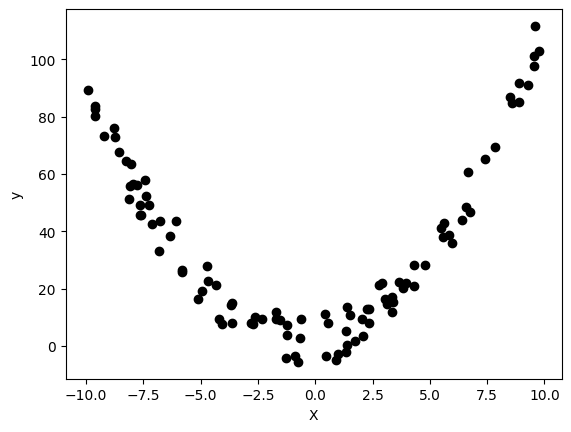

In [4]:
# Visualizzazione del dataset
plt.scatter(X, y, color='black')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [5]:
# Configurazione del regressore simbolico
est = SymbolicRegressor(
    population_size=2000,
    generations=50,
    tournament_size=30,
    stopping_criteria=0.01,
    const_range=(-1.0, 1.0),
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.1,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    parsimony_coefficient=0.01,
    random_state=0
)

In [7]:
# Peggiore in MSE del precedente
est = SymbolicRegressor(
    population_size=2000,  # Aumentato da 1000 a 2000
    generations=50,  # Aumentato da 20 a 50
    tournament_size=15,  # Ridotto da 30 a 15
    stopping_criteria=0.001,  # Ridotto da 0.01 a 0.001
    const_range=(-10.0, 10.0),  # Esteso l'intervallo da (-1, 1) a (-10, 10)
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.1,
    p_point_mutation=0.1,
    max_samples=1.0,  # Modificato da 0.9 a 1
    verbose=1,
    parsimony_coefficient=0.05,  # Modificato da 0.01 a 0.05
    random_state=0
)

In [6]:
# Addestramento del modello
est.fit(X, y)

C:\Users\MrPio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.41           432155        7          4.42691          6.25435      1.48m
   1    28.26          165.915       35          4.18459          5.75269     56.09s
   2    12.44          195.523       17          4.06261          7.04451     44.17s
   3     9.71          28.3301       15          4.01854          6.79279     41.55s
   4     9.19          33.3646       11          3.93983          7.15253     40.97s
   5     9.04          25.6446       15            4.066          6.01697     38.56s
   6     9.53          51.7889        7          4.00134          7.67657     38.22s
   7     9.73          25.0725       13           4.0117           6.3812     36.75s
   8    10.07          439.577       11          3.91558          7.37082  

SymbolicRegressor(generations=50, max_samples=0.9, p_crossover=0.7,
                  p_hoist_mutation=0.1, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=2000, random_state=0, stopping_criteria=0.01,
                  tournament_size=30, verbose=1)

In [7]:
# Calcolo delle previsioni e delle metriche
y_pred = est.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

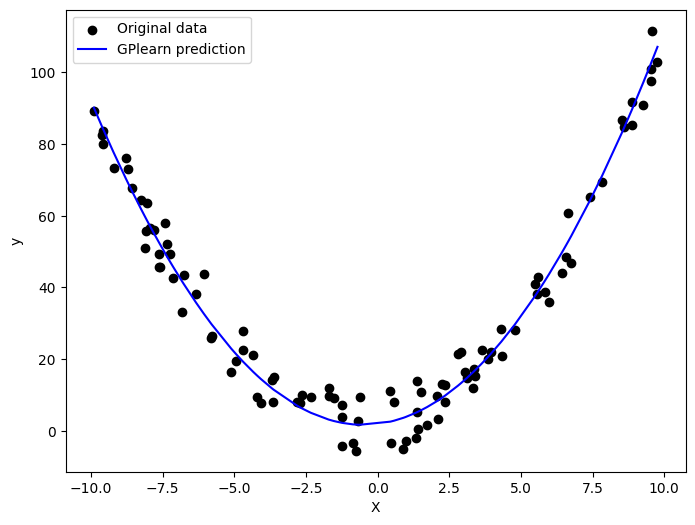

In [19]:
# Ordina i dati per la visualizzazione
sorted_idx = np.argsort(X.flatten())
X_sorted = X[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]

# Visualizzazione dei risultati
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='black', label='Original data')
plt.plot(X_sorted, y_pred_sorted, color='blue', label='GPlearn prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [12]:
# Visualizzazione della formula trovata dal modello
print('Formula trovata dal modello:', est._program)

Formula trovata dal modello: add(mul(X0, X0), add(sub(X0, -0.988), 0.957))


In [13]:
# MSE
print(f"Errore Quadratico Medio: {mse:.4f}")

# Coefficiente di Determinazione (R^2)
print(f"Coefficiente di Determinazione: {r2:.4f}")


Errore Quadratico Medio (MSE): 24.8195
Coefficiente di Determinazione (R^2): 0.9727
